# What is WandB?

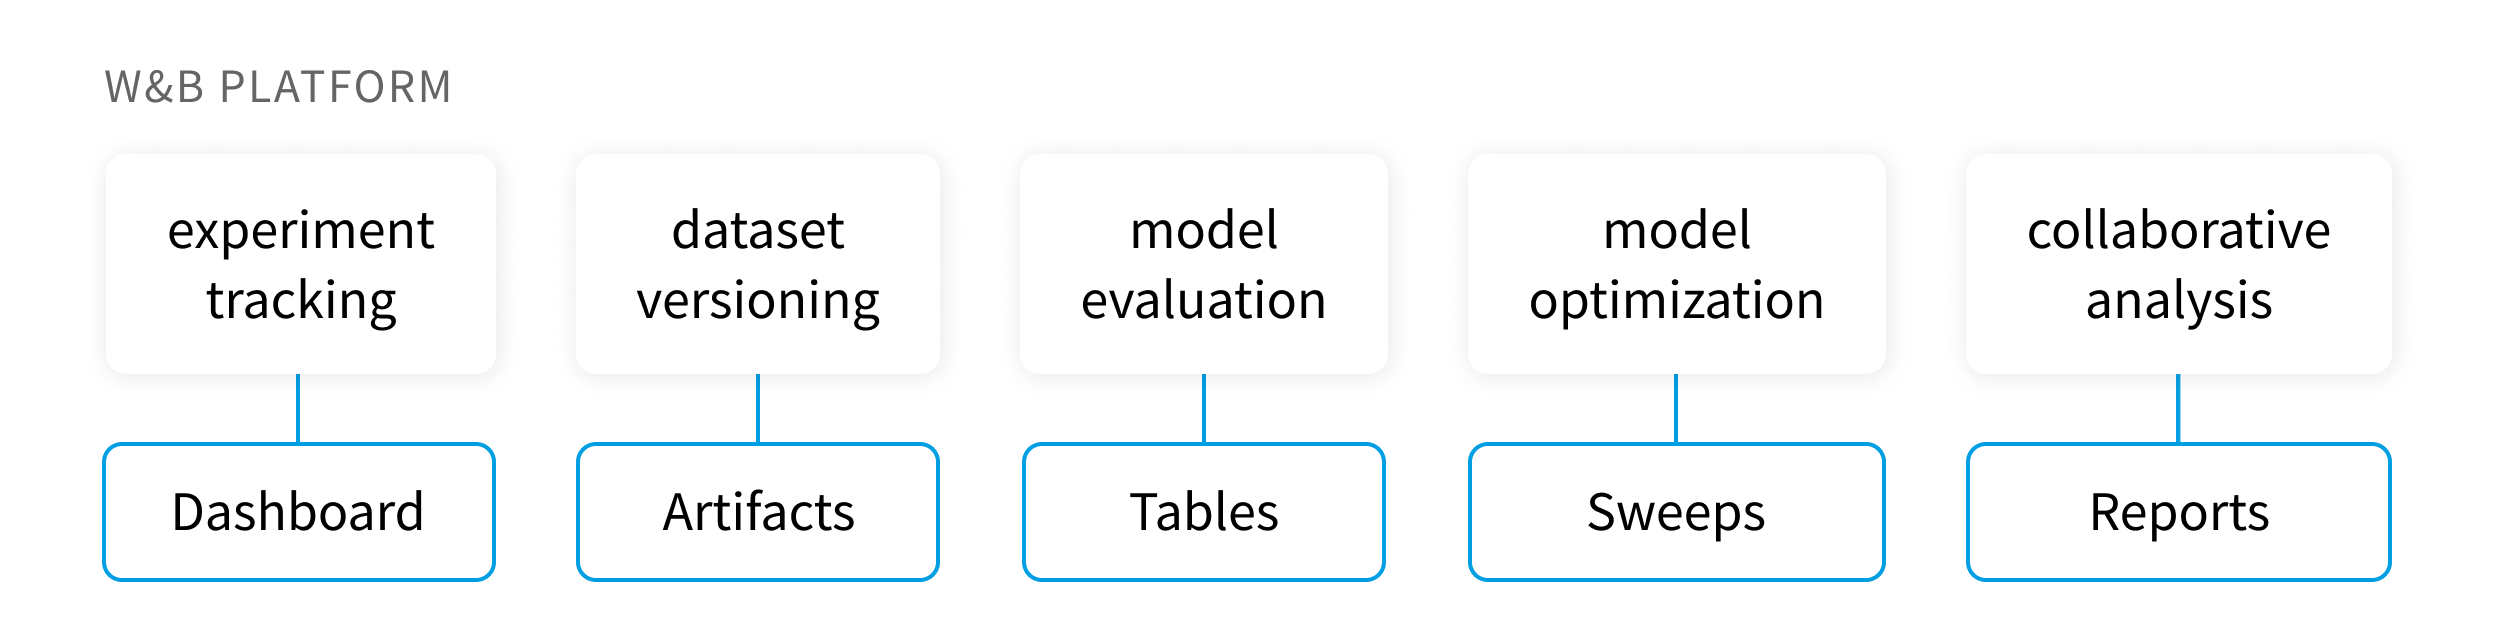

* It is a developer-first MLOps platform. It got tools to automatically log model gradients and parameters,  system metrics like GPU and CPU utilization. The main scope of this platform is for model experiment tracking, dataset versioning, and model management.

* W&B is free for individuals, academics and open source projects.

# Agenda



1.   Add experiment tracking to your model traing pipeline.
2.   Model optimization



# Add experiment tracking

## Pseudocode

```python
# import the library
import wandb

# start a new experiment
wandb.init(project="new-sota-model")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.001, "epochs": 100, "batch_size": 128}

# set up model and data
model, dataloader = get_model(), get_data()

# optional: track gradients
wandb.watch(model)

for batch in dataloader:
  metrics = model.training_step()
  # log metrics inside your training loop to visualize model performance
  wandb.log(metrics)

# optional: save model at the end
model.to_onnx()
wandb.save("model.onnx")
```

## Import libraries

In [ ]:
%%capture
!pip install wandb --upgrade

import wandb
wandb.login()

wandb: Paste an API key from your profile and hit enter: ··········


In [ ]:
import os
import random
import math
import pprint

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets

## Define dataset

In [ ]:
def get_data(slice=5, train=True):
    full_dataset = torchvision.datasets.MNIST(root=".",
                                              train=train, 
                                              transform=transforms.ToTensor(),
                                              download=True)
    sub_dataset = torch.utils.data.Subset(
        full_dataset, indices=range(0, len(full_dataset), slice))
    
    return sub_dataset


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader


## Build model

In [ ]:

def build_network(fc_layer_size, dropout):
    network = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28,fc_layer_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim = 1)
    )
    return network.to(device)

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

def train_epoch(network, loader, optimizer,criterion):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        prediction = network(data)

        loss = criterion(prediction, target)
        cumu_loss += loss.item()
        loss.backward()
        optimizer.step()
        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

def train(model, loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

def train_log(loss, example_ct, epoch):
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

## Define model pipeline

In [ ]:
def model_pipeline(hyperparameters = None):

    # tell wandb to get started
    with wandb.init(project="MLops JODIE", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # Make the data
      train_data, test_data = get_data(train=True), get_data(train=False)
      train_loader = make_loader(train_data, batch_size=config.batch_size)
      test_loader = make_loader(test_data, batch_size=config.batch_size)

      model = build_network(config.fc_layer_size, config.dropout)
      criterion = nn.CrossEntropyLoss()
      optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, test_loader)

    return model

## Define configration and run the pipeline

In [ ]:
config = dict(
    epochs = 3,
    fc_layer_size = 512,
    batch_size = 128,
    dropout = 0.5,
    learning_rate=0.005,
    optimizer="adam")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

wandb: Currently logged in as: praveenkannaj (use `wandb login --relogin` to force relogin)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 03072 examples: 0.544
Loss after 06272 examples: 0.262
Loss after 09472 examples: 0.371
Loss after 12640 examples: 0.249
Loss after 15840 examples: 0.139
Loss after 19040 examples: 0.255
Loss after 22240 examples: 0.111
Loss after 25408 examples: 0.176
Loss after 28608 examples: 0.099
Loss after 31808 examples: 0.188
Loss after 35008 examples: 0.142
Accuracy of the model on the 2000 test images: 95.05%


epoch,▁▁▁▅▅▅▅████
loss,█▄▅▃▂▃▁▂▁▂▂
test_accuracy,▁
epoch,2
loss,0.14226
test_accuracy,0.9505


## Explore a public report

* https://wandb.ai/borisd13/demo_config/reports/Visualize-Track-Compare-Fastai-Models--Vmlldzo4MzAyNA

#  Model optimization with Sweeps

### *Sweep Steps:*
1. Define sweep
2. Initialize the sweep
3. Run the sweep agent

The first thing we need to define is the method for choosing new parameter values.


Pick a method:

* grid Search – Iterate over every combination of hyperparameter values. Very effective, but can be computationally costly.
* random Search – Select each new combination at random according to provided distributions. Surprisingly effective!
* bayesian Search – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.

Docs: https://docs.wandb.ai/guides/sweeps/configuration

### Define the Sweep

In [ ]:
sweep_config = {
    'method': 'random',
    "metric" : {
        'name': 'loss',
        'goal': 'minimize'}
    }

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    'epochs' : {
        'value': 1
        },
    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      }
    }

sweep_config['parameters'] = parameters_dict

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


### **Initialize the Sweep**

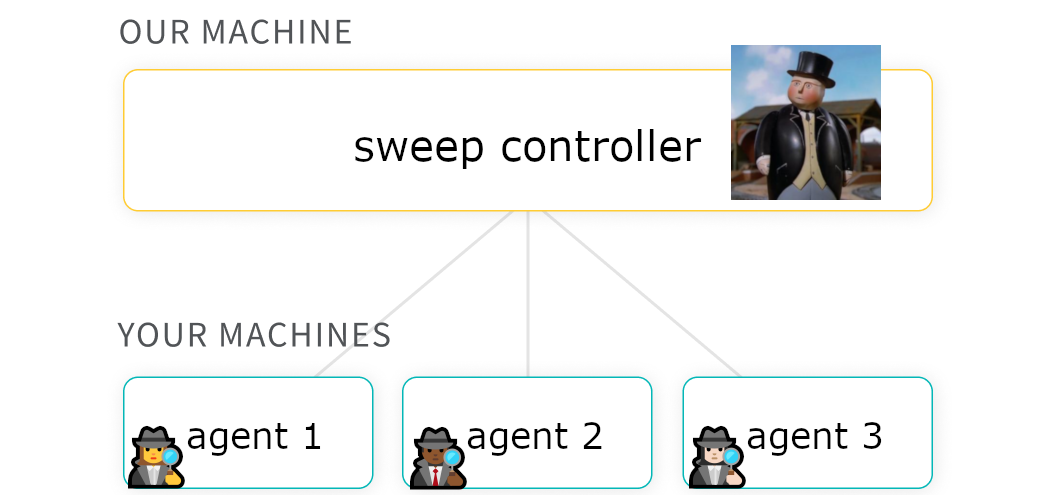

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="MLops JODIE")

Create sweep with ID: j08so4km
Sweep URL: https://wandb.ai/praveenkannaj/MLops%20JODIE/sweeps/j08so4km


### Run the Sweep agent

In [ ]:
wandb.agent(sweep_id, model_pipeline, count=5)

wandb: Agent Starting Run: r15aeq0z with config:
wandb: 	batch_size: 150
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.08382650279485278
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after 03600 examples: 0.570
Loss after 07350 examples: 0.316
Loss after 11100 examples: 0.510
Accuracy of the model on the 2000 test images: 90.5%


epoch,▁▁▁
loss,█▁▆
test_accuracy,▁
epoch,0
loss,0.5104
test_accuracy,0.905


wandb: Agent Starting Run: 1fztrjgn with config:
wandb: 	batch_size: 212
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0979202622600197
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after 05088 examples: 0.648
Loss after 10388 examples: 0.497
Accuracy of the model on the 2000 test images: 88.9%


epoch,▁▁
loss,█▁
test_accuracy,▁
epoch,0
loss,0.49682
test_accuracy,0.889


wandb: Agent Starting Run: o17i2tdx with config:
wandb: 	batch_size: 33
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.005759532574654724
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after 00792 examples: 2.100
Loss after 01617 examples: 1.785
Loss after 02442 examples: 1.253
Loss after 03267 examples: 0.924
Loss after 04092 examples: 0.913
Loss after 04917 examples: 0.650
Loss after 05742 examples: 0.617
Loss after 06567 examples: 0.607
Loss after 07392 examples: 0.464
Loss after 08217 examples: 0.493
Loss after 09042 examples: 0.451
Loss after 09867 examples: 0.381
Loss after 10692 examples: 0.534
Loss after 11517 examples: 0.284
Accuracy of the model on the 2000 test images: 88.1%


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▅▃▃▂▂▂▂▂▂▁▂▁
test_accuracy,▁
epoch,0
loss,0.28401
test_accuracy,0.881


wandb: Agent Starting Run: 2gz9rmck with config:
wandb: 	batch_size: 238
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.04530625857891364
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after 05712 examples: 0.688
Loss after 11662 examples: 0.454
Accuracy of the model on the 2000 test images: 89.3%


epoch,▁▁
loss,█▁
test_accuracy,▁
epoch,0
loss,0.4536
test_accuracy,0.893


wandb: Agent Starting Run: ds2tqgzy with config:
wandb: 	batch_size: 190
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.04739007548364205
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after 04560 examples: 0.822
Loss after 09310 examples: 0.663
Accuracy of the model on the 2000 test images: 89.2%


epoch,▁▁
loss,█▁
test_accuracy,▁
epoch,0
loss,0.66331
test_accuracy,0.892


### Explore Public reports


*   https://wandb.ai/ayush-thakur/image-impainting/runs/2cwkm6k4?workspace=user-praveenkannaj



In [ ]:
#https://docs.wandb.ai/guides/data-vis